<a href="https://colab.research.google.com/github/RobertArbon/art_of_md/blob/master/style_transfer_looped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
# Imports

import numpy as np
import tensorflow as tf

from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
from lucid.optvis.objectives import wrap_objective
import lucid.modelzoo.nets_factory as nets
from os.path import basename
from itertools import product

Globals

In [0]:
# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2


In [4]:
!wget http://francis-bacon.com/sites/default/files/2018-04/innocent-cropped.jpg

--2020-05-25 20:06:28--  http://francis-bacon.com/sites/default/files/2018-04/innocent-cropped.jpg
Resolving francis-bacon.com (francis-bacon.com)... 185.41.10.104
Connecting to francis-bacon.com (francis-bacon.com)|185.41.10.104|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579836 (566K) [image/jpeg]
Saving to: ‘innocent-cropped.jpg’

innocent-cropped.jp 100%[===================>] 566.25K  --.-KB/s    in 0.1s    

2020-05-25 20:06:28 (4.71 MB/s) - ‘innocent-cropped.jpg’ saved [579836/579836]



Arguments

In [0]:
max_layers = 5
style_min = 0.01
style_max = 0.2
style_grid_n = 5
model_name = 'VGG16_caffe'
content_weight=100
max_dim = 512


content_path = "3.jpg"
content_name = basename(content_path).split('.')[0]
style_path = "innocent-cropped.jpg"
style_name = basename(style_path).split('.')[0]

Get model

In [6]:
model = nets.models_map[model_name]()
model.load_graphdef()


Param grid

In [0]:
style_weights = np.logspace(np.log10(style_min), np.log10(style_max), style_grid_n)
style_weights *= content_weight
layers = [x.name for x in model.layers if 'conv' in x.tags]
stride = int(np.floor(len(layers)/max_layers))
layers = layers[::stride]
params = list(product(style_weights, layers, layers))


In [0]:
assert tf.test.is_gpu_available(), 'No GPU!'

In [0]:
def load_img(path_to_img, max_dim=512):
  from PIL import Image
  img = Image.open(path_to_img)
  long = min(img.size)
  scale = max_dim/long
  img = np.asarray(img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), 
                   Image.ANTIALIAS))
  img_max = np.iinfo(img.dtype).max
  npimg = np.divide(img, img_max, dtype=np.float32)
  return npimg

def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]
    
    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]
    
    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses) 
    
  return inner

def gram_matrix(array, normalize_magnitue=True):
  channels = tf.shape(array)[-1]
  array_flat = tf.reshape(array, [-1, channels])
  gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
  if normalize_magnitue:
    length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
  return gram_matrix


In [0]:
content_image = load_img(content_path, max_dim=max_dim)
style_image = load_img(style_path, max_dim=max_dim) 

In [12]:
i = 0
style_weight = params[i][0]
content_layers = [params[i][1]]
style_layers = [params[i][2]]
print(style_weight, content_layers, style_layers)

1.0 ['conv1_1/conv1_1'] ['conv1_1/conv1_1']


In [0]:
param_f = lambda: style_transfer_param(content_image, style_image)

content_obj = content_weight * activation_difference(content_layers, difference_to=CONTENT_INDEX)
content_obj.description = "Content Loss"

style_obj = style_weight*activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
style_obj.description = "Style Loss"

objective = - content_obj - style_obj



In [0]:
vis = render.render_vis(model, objective, param_f=param_f, thresholds=[128, 256], verbose=False, 
                        print_objectives=[content_obj, style_obj])


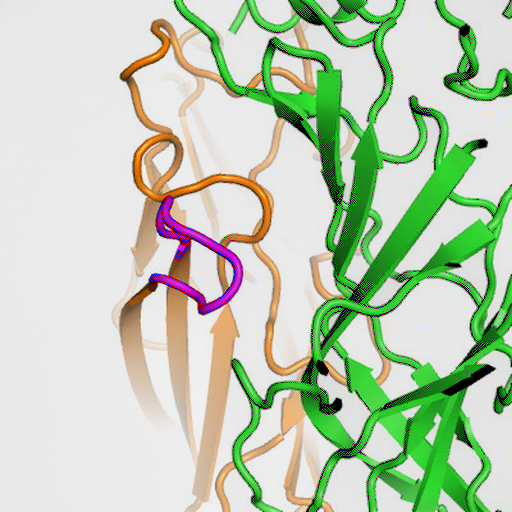
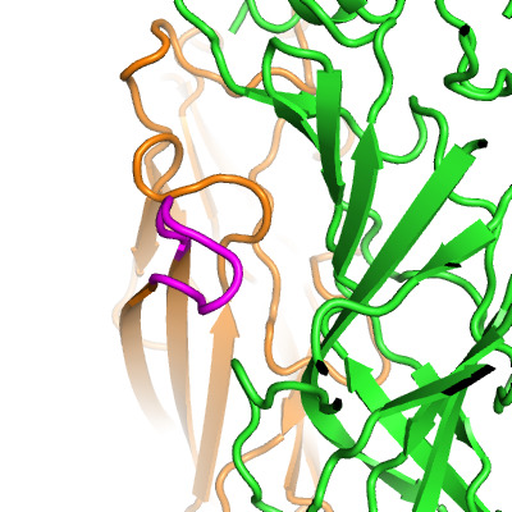
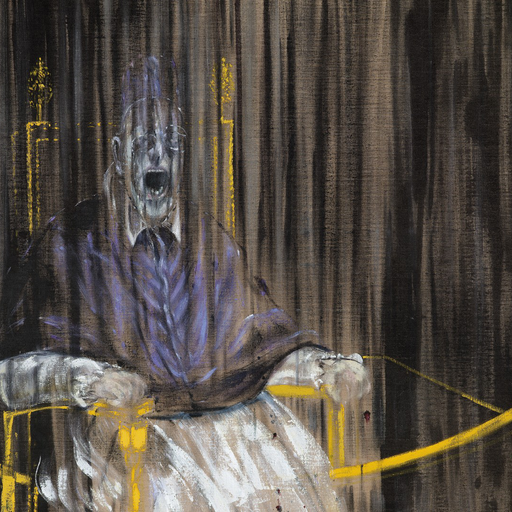

In [19]:
show(vis[-1])